In [1]:
import rebound as rb
import reboundx as rbx
import numpy as np
import matplotlib.pyplot as plt

# Using the force framework

In [27]:
sim = rb.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.add(m = 1)
sim.add(m = 1.e-4, a=0.5, e=0, inc = 0)
sim.move_to_com()

In [28]:
simx = rbx.Extras(sim)

sim.particles[1].params["tau_a"] = -1e3
sim.particles[1].params["tau_e"] = -1e2

ide = simx.load_force("modify_orbits_forces")
simx.add_force(ide)

ide.params["inner_disk_edge_position"] = 0.1
ide.params["disk_edge_width"] = 0.03*(0.1**0.25)                                                    #hedge = 0.03 x (dedge^0.25)
ps = sim.particles

In [29]:
simx = rbx.Extras(sim)

sim.particles[1].params["tau_a"] = -1e3
sim.particles[1].params["tau_e"] = -1e2

ido = simx.load_operator("modify_orbits_direct")
simx.add_operator(ido)

ido.params["inner_disk_edge_position"] = 0.1
ido.params["disk_edge_width"] = 0.03*(0.1**0.25)                                                    #hedge = 0.03 x (dedge^0.25)
ps = sim.particles

In [30]:
sim.integrator = 'whfast'
sim.dt = np.sqrt(0.1**3)/20                              #Period at inner disk edge location divided by 20

In [31]:
times = np.linspace(0, 3e3, 1000)
a_integration = np.zeros((1000))
for i, t in enumerate(times):
    sim.integrate(t)
    a_integration[i] = ps[1].a


a_analytical = np.maximum(0.5*np.exp(-(times)/(1e3)),0.1)

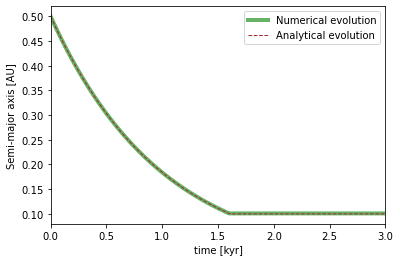

In [32]:
plt.plot(times*0.001, a_integration, label = 'Numerical evolution', c = 'green', linewidth = 4, alpha = 0.6) 
plt.plot(times*0.001, a_analytical, label = 'Analytical evolution', c = 'brown', linestyle = "dashed", linewidth = 1)
plt.xlim(np.min(times)*0.001, np.max(times)*0.001) 
plt.xlabel('time [kyr]')
plt.ylabel('Semi-major axis [AU]')
plt.legend()

# Using operator framework

In [33]:
sim = rb.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.add(m = 1)
sim.add(m = 1.e-4, a=0.5, e=0, inc = 0)
sim.move_to_com()

In [34]:
simx = rbx.Extras(sim)

sim.particles[1].params["tau_a"] = -1e3
sim.particles[1].params["tau_e"] = -1e2

ido = simx.load_operator("modify_orbits_direct")
simx.add_operator(ido)

ido.params["inner_disk_edge_position"] = 0.1
ido.params["disk_edge_width"] = 0.03*(0.1**0.25)                                                    #hedge = 0.03 x (dedge^0.25)
ps = sim.particles

In [35]:
sim.integrator = 'whfast'
sim.dt = np.sqrt(0.1**3)/20                              #Period at inner disk edge location divided by 20

In [36]:
times = np.linspace(0, 3e3, 1000)
a_integration = np.zeros((1000))
for i, t in enumerate(times):
    sim.integrate(t)
    a_integration[i] = ps[1].a


a_analytical = np.maximum(0.5*np.exp(-(times)/(1e3)),0.1)

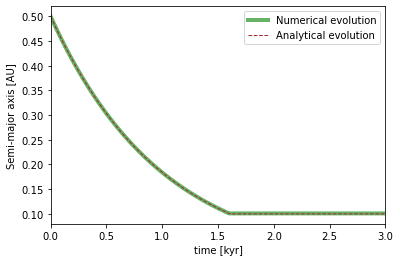

In [37]:
plt.plot(times*0.001, a_integration, label = 'Numerical evolution', c = 'green', linewidth = 4, alpha = 0.6) 
plt.plot(times*0.001, a_analytical, label = 'Analytical evolution', c = 'brown', linestyle = "dashed", linewidth = 1)
plt.xlim(np.min(times)*0.001, np.max(times)*0.001) 
plt.xlabel('time [kyr]')
plt.ylabel('Semi-major axis [AU]')
plt.legend()